In [6]:
import os
import json
import base64
import zlib
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import numpy as np

class HumanMattingDataset(Dataset):
    def __init__(self, img_dir, ann_dir, transform=None):
        self.img_dir = img_dir
        self.ann_dir = ann_dir
        self.images = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
        self.transform = transform
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert('RGB')

        # Load annotation
        ann_path = os.path.join(self.ann_dir, img_name + '.json')
        with open(ann_path, 'r') as file:
            ann = json.load(file)
        
        # Process bitmap data
        alpha_matte = self.decode_bitmap(ann['objects'][0]['bitmap'])
        alpha_matte = Image.fromarray(alpha_matte).convert('L')  # Convert to PIL Image
        
        if self.transform:
            image = self.transform(image)
            alpha_matte = self.transform(alpha_matte)
        
        return image, alpha_matte

    def decode_bitmap(self, bitmap):
        data = bitmap['data']
        origin = bitmap['origin']
        width, height = bitmap['size']['width'], bitmap['size']['height']
        img_data = base64.b64decode(data)
        img_data = zlib.decompress(img_data)
        img_array = np.frombuffer(img_data, dtype=np.uint8)
        img_array = img_array.reshape((height, width))
        return img_array

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])
root_path = "D:\\Casper\\OTHER\\Data\\mattings-human-DatasetNinja\\ds"
# Initialize dataset and data loader
dataset = HumanMattingDataset(f'{root_path}/img', f'{root_path}/ann', transform=transform)


In [2]:
import cv2
import numpy as np
import os


def get_alpha(image):
    """Returns the alpha channel of a given image."""
    if image.shape[2] > 3:
        alpha = image[:, :, 3]
        #alpha = remove_noise(alpha)
    else:
        reduced_image = np.sum(np.abs(255 - image), axis=2)
        alpha = np.where(reduced_image > 100, 255, 0)
    alpha = alpha.astype(np.uint8)
    return alpha


def remove_noise(gray, area_threshold=5000):
    gray = gray.astype(np.uint8)
    ret, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL,
                                   cv2.CHAIN_APPROX_SIMPLE)

    remove_contours = []
    for contour in contours:
        area = cv2.contourArea(contour)
        if area < area_threshold:
            remove_contours.append(contour)
    
    cv2.fillPoly(gray, remove_contours, 0)
    return gray


def to_mask(alpha, threshold=50):
    mask = np.where(alpha > threshold, 1, 0)
    return mask.astype(np.uint8)


def provide(txt_path, delimiter='@'):
    """Returns the paths of images.
    
    Args:
        txt_path: A .txt file with format:
            [image_path_11, image_path_12, ..., image_path_1n,
             image_path_21, image_path_22, ..., image_path_2n,
             ...].
        
    Returns:
        The paths of images.
        
    Raises:
        ValueError: If txt_path does not exist.
    """
    if not os.path.exists(txt_path):
        raise ValueError('`txt_path` does not exist.')
        
    with open(txt_path, 'r') as reader:
        txt_content = np.loadtxt(reader, str, delimiter=delimiter)
        np.random.shuffle(txt_content)
    image_paths = []
    for line in txt_content:
        paths = [x for x in line]
        image_paths.append(paths)
    return image_paths

In [3]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jul 11 20:46:51 2019

@author: shirhe-lyh
"""

import cv2
import numpy as np
import os
import PIL
import torch
import torchvision as tv

# from data import utils


def random_dilate(alpha, low=1, high=5, mode='constant'):
    """Dilation."""
    iterations = np.random.randint(1, 20)
    erode_ksize = np.random.randint(low=low, high=high)
    dilate_ksize = np.random.randint(low=low, high=high)
    erode_kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (erode_ksize, erode_ksize))
    dilate_kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE, (dilate_ksize, dilate_ksize))
    alpha_eroded = cv2.erode(alpha, erode_kernel, iterations=iterations)
    alpha_dilated = cv2.dilate(alpha, dilate_kernel, iterations=iterations)
    if mode == 'constant':
        alpha_noise = 128 * np.ones_like(alpha)
        alpha_noise[alpha_eroded >= 255] = 255
        alpha_noise[alpha_dilated <= 0] = 0
    else:
        value = np.random.randint(low=100, high=255)
        alpha_noise = value * ((alpha_dilated - alpha_eroded) / 255.)
        alpha_noise += alpha_eroded
    return alpha_noise


def crop_offset(trimap, crop_size=320):
    """Generate top-left corner to crop."""
    trimap_ = np.where(trimap == 255, 0, trimap)
    y_indices, x_indices = np.where(trimap_ > 0)
    num_unknowns = len(y_indices)
    y, x = 0, 0
    if num_unknowns > 0:
        index = np.random.randint(low=0, high=num_unknowns)
        xc = x_indices[index]
        yc = y_indices[index]
        y = max(0, yc - crop_size // 2)
        x = max(0, xc - crop_size // 2)
    return y, x


class MattingDataset(torch.utils.data.Dataset):
    """Read dataset for Matting."""
    
    def __init__(self, annotation_path, root_dir=None, transforms=None,
                 output_size=320, dilation_mode='constant'):
        self._transforms = transforms
        self._output_size = output_size
        self._dilation_mode = dilation_mode
        
        # Transform
        if transforms is None:
            channel_means = [0.485, 0.456, 0.406]
            channel_std = [0.229, 0.224, 0.225]
            self._transforms = tv.transforms.Compose([
                tv.transforms.ColorJitter(brightness=32/255., contrast=0.5, 
                                      saturation=0.5, hue=0.2),
                tv.transforms.ToTensor(),
                tv.transforms.Normalize(mean=channel_means, std=channel_std)])
        
        # Format [[image_path, alpha_path], ...]
        self._image_alpha_paths = self.get_image_mask_paths(annotation_path,
                                                            root_dir=root_dir)
        self._remove_invalid_data()
        
    def __getitem__(self, index):
        image_path, alpha_path = self._image_alpha_paths[index]
        image = PIL.Image.open(image_path)
        alpha = PIL.Image.open(alpha_path)
        
        # Rotate
#        degree = np.random.randint(low=-30, high=30)
#        image = image.rotate(degree)
#        alpha = alpha.rotate(degree)
         
        # Crop
        width, height = alpha.size
        min_size = np.min((width, height))
        #crop_sizes = [320, 480, 600, 800] # For Matting_Human_Half
        crop_sizes = [320, 480, 640] # For deep image matting dataset
        crop_size = np.random.choice(crop_sizes)
        if min_size >= crop_size:
            alpha_noise = random_dilate(alpha=np.array(alpha), 
                                        mode=self._dilation_mode)
            height_offset, width_offset = crop_offset(alpha_noise, crop_size)
            box = (width_offset, height_offset, width_offset+crop_size,
                   height_offset+crop_size)
            image = image.crop(box=box)
            alpha = alpha.crop(box=box)
        
        # Resize
        if crop_size > self._output_size or min_size < crop_size:
            image = image.resize((self._output_size, self._output_size),
                                 PIL.Image.ANTIALIAS)
            alpha = alpha.resize((self._output_size, self._output_size),
                                 PIL.Image.NEAREST)
        
        # Flip
        prob = np.random.uniform()
        if prob > 0.5:
            image = image.transpose(PIL.Image.FLIP_LEFT_RIGHT)
            alpha = alpha.transpose(PIL.Image.FLIP_LEFT_RIGHT)
        
        # Dilate, Erode
        alpha = np.array(alpha)
        alpha_noise = random_dilate(alpha, mode=self._dilation_mode)
        mask = np.ones_like(alpha_noise)
        if self._dilation_mode == 'constant':
            mask = np.equal(alpha_noise, 128).astype(np.float32)
        
        alpha = torch.Tensor(alpha / 255.)
        alpha_noise = torch.Tensor(alpha_noise / 255.)
        mask = torch.Tensor(mask)
        # Transform
        image_preprocessed = self._transforms(image)
        alpha_u = torch.unsqueeze(alpha, dim=0)
        mask_u = torch.unsqueeze(mask, dim=0)
        alpha_noise_u = torch.unsqueeze(alpha_noise, dim=0)
        image_concated = torch.cat([image_preprocessed, alpha_noise_u], dim=0)
        return image_concated, alpha_u, alpha_noise_u, mask_u
    
    def __len__(self):
        return len(self._image_alpha_paths)
    
    def get_image_mask_paths(self, annotation_path, root_dir=None):
        """Get the paths of images and masks.
        
        Args:
            annotation_path: A file contains the paths of images and masks.
            
        Returns:
            A list [[image_path, mask_path], [image_path, mask_path], ...].
            
        Raises:
            ValueError: If annotation_file does not exist.
        """
        # Format: [[image_path, matting_path, alpha_path, mask_path], ...]
        image_matting_alpha_mask_paths = provide(annotation_path)
        # Remove matting_paths, mask_paths
        image_alpha_paths = []
        for image_path, _, alpha_path, _ in image_matting_alpha_mask_paths:
            if root_dir is not None:
                if not image_path.startswith(root_dir):
                    image_path = os.path.join(root_dir, image_path)
                    alpha_path = os.path.join(root_dir, alpha_path)
                    image_path = image_path.replace('\\', '/')
                    alpha_path = alpha_path.replace('\\', '/')
            image_alpha_paths.append([image_path, alpha_path])
        return image_alpha_paths
            
    def _remove_invalid_data(self):
        valid_data = []
        for image_path, alpha_path in self._image_alpha_paths:
            if not os.path.exists(image_path):
                continue
            if not os.path.exists(alpha_path):
                continue
            valid_data.append([image_path, alpha_path])
        self._image_alpha_paths = valid_data
        

In [4]:
root_path = "D:\\Casper\\OTHER\\Data\\mattings-human-DatasetNinja\\ds"


In [8]:
matting_dataset = MattingDataset(annotation_path=root_path)

NameError: name 'utils' is not defined

In [1]:
import os
import cv2
import argparse
import numpy as np
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torchvision.transforms as transforms

from modnet import MODNet


torch_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)


def matting(video, result, alpha_matte=False, fps=30):
    # video capture
    vc = cv2.VideoCapture(video)

    if vc.isOpened():
        rval, frame = vc.read()
    else:
        rval = False

    if not rval:
        print('Failed to read the video: {0}'.format(video))
        exit()

    num_frame = vc.get(cv2.CAP_PROP_FRAME_COUNT)
    h, w = frame.shape[:2]
    if w >= h:
        rh = 512
        rw = int(w / h * 512)
    else:
        rw = 512
        rh = int(h / w * 512)
    rh = rh - rh % 32
    rw = rw - rw % 32

    # video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(result, fourcc, fps, (w, h))

    print('Start matting...')
    with tqdm(range(int(num_frame)))as t:
        for c in t:
            frame_np = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_np = cv2.resize(frame_np, (rw, rh), cv2.INTER_AREA)

            frame_PIL = Image.fromarray(frame_np)
            frame_tensor = torch_transforms(frame_PIL)
            frame_tensor = frame_tensor[None, :, :, :]
            if GPU:
                frame_tensor = frame_tensor.cuda()

            with torch.no_grad():
                _, _, matte_tensor = modnet(frame_tensor)

            matte_tensor = matte_tensor.repeat(1, 3, 1, 1)
            matte_np = matte_tensor[0].data.cpu().numpy().transpose(1, 2, 0)
            if alpha_matte:
                view_np = matte_np * np.full(frame_np.shape, 255.0)
            else:
                view_np = matte_np * frame_np + (1 - matte_np) * np.full(frame_np.shape, 255.0)
            view_np = cv2.cvtColor(view_np.astype(np.uint8), cv2.COLOR_RGB2BGR)
            view_np = cv2.resize(view_np, (w, h))
            video_writer.write(view_np)

            rval, frame = vc.read()
            c += 1

    video_writer.release()
    print('Save the result video to {0}'.format(result))


    # parser = argparse.ArgumentParser()
    # parser.add_argument('--video', type=str, required=True, help='input video file')
    # parser.add_argument('--result-type', type=str, default='fg', choices=['fg', 'matte'], 
    #                     help='matte - save the alpha matte; fg - save the foreground')
    # parser.add_argument('--fps', type=int, default=30, help='fps of the result video')

    # print('Get CMD Arguments...')
    # args = parser.parse_args()

    # if not os.path.exists(args.video):
    #     print('Cannot find the input video: {0}'.format(args.video))
    #     exit()

print('Load pre-trained MODNet...')
pretrained_ckpt = 'D:\\Casper\\OTHER\\Weight\\MLS\\hw4\\modnet_webcam_portrait_matting.ckpt'
modnet = MODNet(backbone_pretrained=False)
modnet = nn.DataParallel(modnet)

GPU = True if torch.cuda.device_count() > 0 else False
if GPU:
    print('Use GPU...')
    modnet = modnet.cuda()
    modnet.load_state_dict(torch.load(pretrained_ckpt))
else:
    print('Use CPU...')
    modnet.load_state_dict(torch.load(pretrained_ckpt, map_location=torch.device('cpu')))
modnet.eval()

vid_path = "D:\\Casper\\MLSystemDesign\\IMG_3959.mp4"
img_path = "D:\\Casper\\MLSystemDesign\\MLSystemDesign\\hw4\\1803151818-00000004.jpg"

# result = vid_path.format('fg')
# alpha_matte =  False
# matting(vid_path, result, alpha_matte, 30)
# img_path
# frame_PIL = Image.fromarray(img_path)
# frame_tensor = torch_transforms(frame_PIL)
# frame_tensor = frame_tensor[None, :, :, :]
# if GPU:
#     frame_tensor = frame_tensor.cuda()

# with torch.no_grad():
#     _, _, matte_tensor = modnet(frame_tensor)
# result = os.path.splitext(vid_path)
# alpha_matte = True if args.result_type == 'matte' else False
# matting(args.video, result, alpha_matte, args.fps)

Load pre-trained MODNet...
Use GPU...


In [9]:
frame_np = cv2.imread(img_path, cv2.COLOR_BGR2RGB)
h, w = frame_np.shape[:2]
print(h,w )
if w >= h:
    rh = 512
    rw = int(w / h * 512)
else:
    rw = 512
    rh = int(h / w * 512)
rh = rh - rh % 32
rw = rw - rw % 32
frame_np = cv2.resize(frame_np, (rw, rh), cv2.INTER_AREA)
frame_PIL = Image.fromarray(frame_np)
frame_tensor = torch_transforms(frame_PIL)
frame_tensor = frame_tensor[None, :, :, :]
if GPU:
    frame_tensor = frame_tensor.cuda()

with torch.no_grad():
    matte_tensor = modnet(frame_tensor)

800 600


In [10]:
print(matte_tensor.shape)


torch.Size([1, 1, 672, 512])


In [12]:
matte_tensor = matte_tensor.repeat(1, 3, 1, 1)
matte_np = matte_tensor[0].data.cpu().numpy().transpose(1, 2, 0)
view_np = matte_np * frame_np + (1 - matte_np) * np.full(frame_np.shape, 255.0)
view_np.shape

(672, 512, 3)

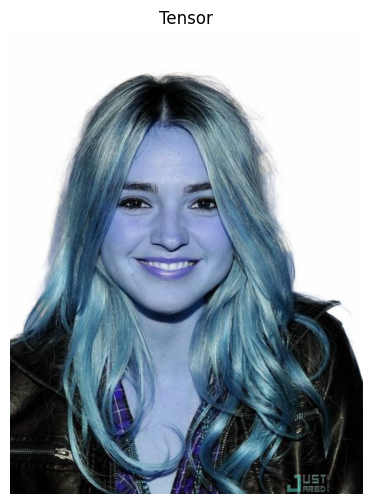

In [14]:
import matplotlib.pyplot as plt
def plot_np(tensor, title="Tensor", normalize=True):
    tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())  # Normalize to [0, 1]

    plt.figure(figsize=(6, 6))
    plt.imshow(tensor, cmap='rgb' if tensor.ndim == 2 else None)
    plt.title(title)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
plot_np(view_np)

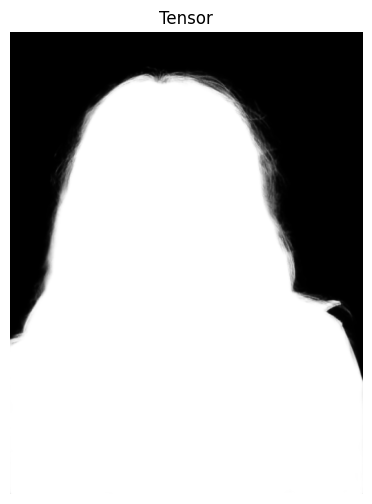

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_tensor(tensor, title="Tensor", normalize=True):
    """
    Plot a PyTorch Tensor as an image.

    Args:
        tensor (torch.Tensor): The image tensor to plot. Expected shape (C, H, W) or (H, W).
        title (str, optional): Title of the plot. Defaults to "Tensor".
        normalize (bool, optional): Flag to normalize the tensor to [0, 1]. Defaults to True.
    """
    # Check if the tensor has channels first format and fix if necessary
    if tensor.ndim == 3 and tensor.shape[0] in [1, 3]:  # C, H, W
        tensor = tensor.permute(1, 2, 0)  # Convert to H, W, C for plotting
    tensor = tensor.detach().cpu().numpy()  # Convert to numpy array

    if tensor.shape[2] == 1:  # If single channel, squeeze it
        tensor = np.squeeze(tensor, axis=2)

    if normalize:
        tensor = (tensor - tensor.min()) / (tensor.max() - tensor.min())  # Normalize to [0, 1]

    plt.figure(figsize=(6, 6))
    plt.imshow(tensor, cmap='gray' if tensor.ndim == 2 else None)
    plt.title(title)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
plot_tensor(matte_tensor[0])

In [ ]:
def matting_live(camera_index, result, alpha_matte=False, fps=30):
    # Set up video capture from camera
    vc = cv2.VideoCapture(camera_index)

    if not vc.isOpened():
        print('Failed to open the camera')
        return

    # Set up video writer for output
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    _, frame = vc.read()
    h, w = frame.shape[:2]  # Get dimensions of the frame
    video_writer = cv2.VideoWriter(result, fourcc, fps, (w, h))

    print('Start matting...')

    try:
        while True:
            rval, frame = vc.read()
            if not rval:
                print("Failed to read frame from camera.")
                break
            
            # Resize and prepare the frame
            if w >= h:
                rh = 512
                rw = int(w / h * 512)
            else:
                rw = 512
                rh = int(h / w * 512)
            rh = rh - rh % 32
            rw = rw - rw % 32
            
            frame_np = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            frame_np = cv2.resize(frame_np, (rw, rh), cv2.INTER_AREA)
            frame_PIL = Image.fromarray(frame_np)
            frame_tensor = transforms.ToTensor()(frame_PIL).unsqueeze(0)

            # Assuming the use of a GPU if available
            if torch.cuda.is_available():
                frame_tensor = frame_tensor.cuda()

            # Model inference
            with torch.no_grad():
                matte_tensor = modnet(frame_tensor)[2]  # Assuming model returns matte at index 2

            matte_tensor = matte_tensor.repeat(1, 3, 1, 1)
            matte_np = matte_tensor[0].data.cpu().numpy().transpose(1, 2, 0)

            # Create the composite image based on alpha_matte flag
            if alpha_matte:
                view_np = matte_np * np.full(frame_np.shape, 255.0)
            else:
                view_np = matte_np * frame_np + (1 - matte_np) * np.full(frame_np.shape, 255.0)

            view_np = cv2.cvtColor(view_np.astype(np.uint8), cv2.COLOR_RGB2BGR)
            view_np = cv2.resize(view_np, (w, h))
            video_writer.write(view_np)

    except KeyboardInterrupt:
        print("Stopped by user.")

    video_writer.release()
    vc.release()
    print('Saved the result video to {0}'.format(result))
matting_live(0, )

In [2]:
import cv2
import supervisely as sly
ann_path = "D:\\Casper\\OTHER\\Data\\mattings-human-DatasetNinja\\ds\\ann\\1803151818-00000003.jpg.json"
ann_json = json.load(open(ann_path))
# inputt = "./lemons-fs"
# project = sly.Project(inputt, sly.OpenMode.READ)
# ann = sly.Annotation.from_json(ann_json, project.meta)

# bitmap = {"data": "eJwBRQe6+IlQTkcNChoKAAAADUlIRFIAAAI9AAADAgEDAAAAuATljgAAAAZQTFRFAAAA////pdmf3QAAAAF0Uk5TAEDm2GYAAAbtSURBVHic7dy9jiQ1EAfwHVawARIOgQA1b7BkJEjmTY43IIQINyIh5HHI1ogHYAPybQQB2bbgJObuhjEss7d0+6Ntl/897empyk46/WS3y+Xy7p0vLmIhu+hfSQu1BSBX7b/Qrty5NN3FxhgEtH2AyucmjOmUMftiqDHmhTGAuQlzCMSIDtEVQvI1ZDQK6ksYYQZRAl0NnKIMkMMRdVTl8stvDAQSL1CQsUKjoJYISRuiSsqBeppz70C0Qukw1Jz8yiN9S3AuPQ5pbs7iU6HGB1HOAIka0ZUPgo2IUNw+9joESKEgv5O/bTd+J3+PeNeMMjURgHQu9DkKCjjZpS3wrfOh0CfK3mxNCMpd/5sQlLn+wU+Um9owKJTXJrcBECioCUN9FiTDUF4iwSAVhrIycmL18zLSe1q/jjYDmkijvPWHQWIK6lFQzqndoCA1BeUk0pSDgzISaTKxgdB3yZCYhm6ToQ9QUHMk6DlDk6X/IdLL/7STntqRxE6HJkv/Q3Qo6KNE6O0YlFojmxiUumwSBakYlHpqx6EWBWkU1KOgtPWP7pDkZUNBsBElQGmn9psoaLJde4zjQtcJUJsCSRR0c0xIo6AuBUpwcFBfHZRSkKLH40N8j4JS6kgS9NsxIXGa0N8nCT1LgVJqrTpRSEedhHP27KFot36IPgqJNOiPKHSdBr08HiTToHirxRAMirdaNygo0akQ0iioqw7qI07C1egQsR8iJUOxni3lanRc6N2jQ7HTHwY1x4daFNShoMi9ZgEoUv7TociyZUB6ElILQN1pQW9kQLdT0Fso6B0YlO5MQ00G1FcHTe5amQFNniMqZ0QtCJqs2jlTw0HdMSCVA02U/8R76GNMrP9C0MQ5shT0aRBKbvwOoYOQXAjqUVA4I9VCUDgj85yJYrsUFC5tuZBGQd16of5koMy6Ft4jSb+AOCqUWWmBUGjXZkOhAwkGiWyo9UNNNqRRUIeC+uqgwMm2YkhmQ4Fdmw8Fdq1aDgrs2nwnMCKGhjEzpBgaRDsvlO/4z6Ps9sgEqv+ikLfWrmNqK4Y6H5TdHZtAZue3kAFIECDv1BaFvKtGgbx7jaHKIdjyM8QQQwtClHPNW0YokPcuytARIUp/BBuR9y5Kgby3GsFQ5ZCuDurWC/UoyFf9l4V8Bak+SC4K+WotDBKLQr6fssmVQC3qG2kXIp20OKh3IUo3AoQ8BYk2tfogTx2hQZ5du2JILAt5tj8R0g50TYM6FNSjIHePECF3jxAhd/0lQ3NB7qqtBnLbCEWE2uqg+aZGdNwSSYU6y6H8MssLwUbE0ClCsDwiQxo1tfkgxZAd9vKTIafTgkFEx4E297VBwbdujwY57cg9CCKXERui3daN20TS7n0nAZE/NkNrgMgVcjaovk0rUFCDgiQKUiiI6uAg++ZHh1oUpBlaCLr6AQQJujMTVPCJLEitCWpngXYgaFMCjb4RnbEgWR1URWaP80iioIYOjZyCOmKdtOT2yIbIDdtsI6pvahX0RxZEvkHYCUn/RnNB9KnZH/uvxSG7GaVDGpRHFR7ZFyBoPxdEXjXrPc0NCqLnkQ19gYLSn6uzwv6BJgr6rKFCL1HQq5Hz3i/PyFA7hOSvVMe80qPEpkNWV1sADae2KYHGIyqI0WvasgDazwKJP1FQwcceQVc/gqCSJmIM0XtIHDQ+IQumtmLobgQVfOw7VB79PIIK+uzbEVRQkWBQv17o+XqhHUPnDO1RkFkx1I4gRYf0CGroUDeG7lEQakQSBRWM6HfU8o+ufgVH9njXChTUFEBb1IgG0GUnC6DB8pcwQ+j9ImcAKRD0U5nzP1To4KAeBW1R0A4F7VGQqQ6CTW3NH7tFQRoFddVBsKkxFI/6lr9HQVsUZLYfgqDHr8TQaUE9QwwBoC1DDAGgHUNnDO0/wUB3O1B/hIMMqmN7vGgBIF1dNwKD6puaYYghBNQydIKQZuicoY4hhmqCeoYYAsSWIYZqgnYMnTO0Z4ghRDDEECJahhgChGaIoZqgbt2QREHNQwlQ1UHi8OevSyDRPh2THfnf+/dPUGMe7oFF0CE2/10oANATh4HI2Tnbk6wMueE8yaoYssN5uJKh+SDnOX6G3GjPB6I6zqPlKIj+f/3mgugvD8CgbgzRH1WYCxLLQ/1MUMOQG1uGorGbCRIoiF6PLIheau0mkgzBHlOs/i1NQYasBqlBQbI6SKEgujPutEpeMBhBsBeeYK9gieqgBgVJFKRQUIFjPcsHgkrycQSV5OMIEiioQUGyOkitFypx6oaK9mzdUFEVqRsqqmt1Q2K9ULNeSNYB6RkgxVAUKnKqhspOo6qhstNo8DPWFUNlxxpDDEGg/hwgwRBDy0PbiqGmFugf5PP0tFJUOjYAAAAASUVORK5CYIIbCUWS",
#                 "origin": [
#                     0,
#                     30
#                 ]}
# data = bitmap['data']
# origin = bitmap['origin']
# width, height = 600, 800
# print(len(data))
# img_data = base64.b64decode(data)
# cv2_img_data = cv2.imdecode(data,0)
# print(len(img_data))
# print(len(cv2_img_data))
# # img_data = zlib.decompress(img_data)

# img_array = np.frombuffer(img_data, dtype=np.uint8)
# img_array = img_array.reshape((height, width))
# img_array

In [1]:
import supervisely as sly


In [4]:
import os
import json

from tqdm import tqdm
root_path = "D:\\Casper\\OTHER\\Data\\mattings-human-DatasetNinja\\"
print("start")
import supervisely as sly
inputs = f"{root_path}/ds"
output = f"{root_path}/results"
os.makedirs(output, exist_ok=True)
print("new folder")

# Creating Supervisely project from local directory.
project = sly.Project(inputs, sly.OpenMode.READ)
print("Opened project: ", project.name)
print("Number of images in project:", project.total_items)

# Showing annotations tags and classes.
print(project.meta)

# Iterating over classes in project, showing their names, geometry types and colors.
for obj_class in project.meta.obj_classes:
    print(
        f"Class '{obj_class.name}': geometry='{obj_class.geometry_type}', color='{obj_class.color}'",
    )

# Iterating over tags in project, showing their names and colors.
for tag in project.meta.tag_metas:
    print(f"Tag '{tag.name}': color='{tag.color}'")

print("Number of datasets (aka folders) in project:", len(project.datasets))

progress = tqdm(project.datasets, desc="Processing datasets")
for dataset in project.datasets:
    # Iterating over images in dataset, using the paths to the images and annotations.
    for item_name, image_path, ann_path in dataset.items():
        print(f"Item '{item_name}': image='{image_path}', ann='{ann_path}'")

        ann_json = json.load(open(ann_path))
        ann = sly.Annotation.from_json(ann_json, project.meta)

        img = sly.image.read(image_path)  # rgb - order

        for label in ann.labels:
            # Drawing each label on the image.
            label.draw(img)

        res_image_path = os.path.join(output, item_name)
        sly.image.write(res_image_path, img)

        # Or alternatively draw annotation (all labels at once) preview with
        # ann.draw_pretty(img, output_path=res_image_path)

        progress.update(1)

start


In [3]:
print('hehe')

hehe


In [ ]:
import os
import json

import supervisely as sly
from tqdm import tqdm

inputt = "./lemons-fs"
output = "./results"
os.makedirs(output, exist_ok=True)

# Creating Supervisely project from local directory.
project = sly.Project(inputt, sly.OpenMode.READ)
print("Opened project: ", project.name)
print("Number of images in project:", project.total_items)

# Showing annotations tags and classes.
print(project.meta)

# Iterating over classes in project, showing their names, geometry types and colors.
for obj_class in project.meta.obj_classes:
    print(
        f"Class '{obj_class.name}': geometry='{obj_class.geometry_type}', color='{obj_class.color}'",
    )

# Iterating over tags in project, showing their names and colors.
for tag in project.meta.tag_metas:
    print(f"Tag '{tag.name}': color='{tag.color}'")

print("Number of datasets (aka folders) in project:", len(project.datasets))

progress = tqdm(project.datasets, desc="Processing datasets")
for dataset in project.datasets:
    # Iterating over images in dataset, using the paths to the images and annotations.
    for item_name, image_path, ann_path in dataset.items():
        print(f"Item '{item_name}': image='{image_path}', ann='{ann_path}'")

        ann_json = json.load(open(ann_path))
        ann = sly.Annotation.from_json(ann_json, project.meta)

        img = sly.image.read(image_path)  # rgb - order

        for label in ann.labels:
            # Drawing each label on the image.
            label.draw(img)

        res_image_path = os.path.join(output, item_name)
        sly.image.write(res_image_path, img)

        # Or alternatively draw annotation (all labels at once) preview with
        # ann.draw_pretty(img, output_path=res_image_path)

        progress.update(1)

In [6]:
import random
from torch.utils.data import DataLoader, Subset
def get_dataloaders(dataset, train_ratio, val_ratio, batch_size, seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    train_dataset = dataset
    val_dataset = dataset
    test_dataset = dataset
    # obtain training indices that will be used for validation
    num_train = len(test_dataset)
    indices = list(range(num_train))
    print("--------- INDEX checking ---------")
    print(f"Original: {indices[:5]}")
    random.shuffle(indices)
    print(f"Shuffled: {indices[:5]}")
    print("--------- INDEX shuffled ---------\n")

    split_train = int(np.floor(train_ratio * num_train))
    split_val = split_train + int(np.floor(val_ratio * (num_train-split_train)))
    train_idx, val_idx, test_idx = indices[0:split_train], indices[split_train:split_val], indices[split_val:]
    merge_dataset = Subset(train_dataset, train_idx)

    train_loader = DataLoader(merge_dataset, batch_size=batch_size)
    val_loader = DataLoader(Subset(val_dataset, val_idx), batch_size=batch_size)
    test_loader = DataLoader(Subset(test_dataset, test_idx), batch_size=batch_size)
    
    # check dataset
    print(f"Total number of samples: {num_train} datapoints")
    print(f"Number of train samples: {len(train_loader)} batches/ {len(train_loader.dataset)} datapoints")
    print(f"Number of val samples: {len(val_loader)} batches/ {len(val_loader.dataset)} datapoints")
    print(f"Number of test samples: {len(test_loader)} batches/ {len(test_loader.dataset)} datapoints")
    print(f"")
    
    dataloaders = {
        "train": train_loader,
        "val": val_loader,
        "test": test_loader,
    }
    return dataloaders
dataloaders = get_dataloaders(dataset, 0.8, 0.5, 64, 6452916)


--------- INDEX checking ---------
Original: [0, 1, 2, 3, 4]
Shuffled: [15856, 22128, 31295, 6264, 18091]
--------- INDEX shuffled ---------

Total number of samples: 34425 datapoints
Number of train samples: 431 batches/ 27540 datapoints
Number of val samples: 54 batches/ 3442 datapoints
Number of test samples: 54 batches/ 3443 datapoints



In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = DoubleConv(64, 128)
        self.down2 = DoubleConv(128, 256)
        self.down3 = DoubleConv(256, 512)
        self.up1 = DoubleConv(512 + 256, 256)
        self.up2 = DoubleConv(256 + 128, 128)
        self.up3 = DoubleConv(128 + 64, 64)
        self.outc = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = F.max_pool2d(x1, 2)
        x2 = self.down1(x2)
        x3 = F.max_pool2d(x2, 2)
        x3 = self.down2(x3)
        x4 = F.max_pool2d(x3, 2)
        x4 = self.down3(x4)
        x = F.interpolate(x4, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x3], dim=1)
        x = self.up1(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x2], dim=1)
        x = self.up2(x)
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        x = torch.cat([x, x1], dim=1)
        x = self.up3(x)
        logits = self.outc(x)
        return logits



In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNet(n_channels=3, n_classes=1).to(device)  # for grayscale matte prediction
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

def train(model, dataloader, optimizer,criterion, epochs):
    model.train()
    for epoch in range(epochs):
        for images, mattes in dataloaders['train']:
            images = images.to(device)
            mattes = mattes.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, mattes)
            loss.backward()
            optimizer.step()
            print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Placeholder for your data loader
train_loader = None  # You need to define this based on your dataset
train(model, train_loader, optimizer,criterion, epochs=10)


KeyError: 'size'